# Figure 2 Grid Recreation (Strict Win Rate)

This notebook builds `k_bar` vs `sigma_t` from logs and produces:
1. A **2x3 grid** (rows: model `EDM`/`SD`; cols: `brightness`, `compressibility`, `classifier/clip`)
2. An **overlay plot** with all six curves
3. **Model-level aggregates** (`EDM`, `SD`)
4. **Global vs local path win-rate plots** using **strict** comparison (`best_global > best_local`)

`k_bar` is computed from best-so-far global-path indicator; strictness for win-rate plots is controlled by `STRICT_WIN_RATE`.


In [15]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import LogLocator, LogFormatterMathtext

plt.style.use('seaborn-v0_8-whitegrid')


In [16]:
# -------- Config --------
EXPERIMENT_NAME = 'inefficiency'
ROOT_LOG_BASE = Path('../logs/search_stats')

# If True, plot k_bar/19 (so all-random baseline is 10 for K=20).
NORMALIZE_BY_19 = True

# Tie handling for best-so-far indicator:
# True => I_k=1 when G_so_far >= L_so_far
# False => I_k=1 only when G_so_far > L_so_far
TIE_AS_GLOBAL = True

# Strictness for win-rate metrics:
# True  => global wins when best_global > best_local; ties use logged selected source
# False => follow TIE_AS_GLOBAL policy (>= when TIE_AS_GLOBAL=True)
STRICT_WIN_RATE = True

MODELS = ['EDM', 'SD']
COL_KEYS = ['brightness', 'compressibility', 'classifier_or_clip']
COL_LABELS = {
    'brightness': 'Brightness',
    'compressibility': 'Compressibility',
    'classifier_or_clip': 'Classifier / CLIP',
}
REWARD_DIR_BY_MODEL = {
    'EDM': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLASSIFIER',
    },
    'SD': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLIP',
    },
}

# Optional manual x-limits by model.
# Set to None to auto-infer from available sigma_t values for that model.
X_LIM_BY_MODEL = {
    'EDM': None,
    'SD': None,
}

# Axis scale by model
# EDM uses sigma-like values -> log
# SD can be easier to read as linear
X_SCALE_BY_MODEL = {
    'EDM': 'log',
    'SD': 'linear',
}

ROOT_LOG_BASE / EXPERIMENT_NAME





PosixPath('../logs/search_stats/inefficiency')

In [17]:
def compute_kbar_curve_from_log_dir(
    log_dir: Path,
    normalize_by_19: bool = True,
    tie_as_global: bool = True,
    strict_win_rate: bool = True,
):
    files = sorted(log_dir.rglob('*.jsonl'))
    if not files:
        return None, None, None, None, {
            'log_dir': str(log_dir),
            'num_files': 0,
            'num_rows': 0,
            'num_units': 0,
            'num_win_units': 0,
        }

    rows = []
    for fp in files:
        with fp.open('r', encoding='utf-8') as f:
            for line in f:
                if not line.strip():
                    continue
                e = json.loads(line)
                if e.get('event_type') != 'candidate_eval':
                    continue
                rows.append({
                    'source': str(fp),
                    'sample_idx': int(e.get('sample_idx', 0)),
                    'timestep_idx': int(e['timestep_idx']),
                    'sigma_t': float(e.get('timestep_value', np.nan)),
                    'local_iter_idx': int(e['local_iter_idx']),
                    'is_global_candidate': bool(e['is_global_candidate']),
                    'score': float(e['score']),
                    'is_winner': bool(e.get('is_winner', False)),
                    'winner_is_global_current_logged': (
                        None if e.get('winner_is_global_current') is None else bool(e.get('winner_is_global_current'))
                    ),
                })

    if not rows:
        return None, None, None, None, {
            'log_dir': str(log_dir),
            'num_files': len(files),
            'num_rows': 0,
            'num_units': 0,
            'num_win_units': 0,
        }

    df = pd.DataFrame(rows)
    keys = ['source', 'sample_idx', 'timestep_idx', 'local_iter_idx']

    iter_scores = (
        df.groupby(keys, as_index=False)
          .agg(
              sigma_t=('sigma_t', 'first'),
              best_global_score=(
                  'score',
                  lambda s: (
                      float(s[df.loc[s.index, 'is_global_candidate']].max())
                      if df.loc[s.index, 'is_global_candidate'].any()
                      else np.nan
                  ),
              ),
              best_local_score=(
                  'score',
                  lambda s: (
                      float(s[~df.loc[s.index, 'is_global_candidate']].max())
                      if (~df.loc[s.index, 'is_global_candidate']).any()
                      else np.nan
                  ),
              ),
          )
          .sort_values(['source', 'sample_idx', 'timestep_idx', 'local_iter_idx'])
          .reset_index(drop=True)
    )

    # Recover actual selected source at each (source, sample, t, k) from winner row.
    winner_map = (
        df[df['is_winner']]
        .groupby(keys, as_index=False)
        .agg(selected_global_from_winner=('is_global_candidate', 'first'))
    )

    def _first_non_null_bool(s):
        s = s.dropna()
        if len(s) == 0:
            return np.nan
        return bool(s.iloc[0])

    logged_map = (
        df.groupby(keys, as_index=False)
          .agg(selected_global_logged=('winner_is_global_current_logged', _first_non_null_bool))
    )

    iter_scores = iter_scores.merge(winner_map, on=keys, how='left')
    iter_scores = iter_scores.merge(logged_map, on=keys, how='left')
    iter_scores['selected_global_current'] = iter_scores['selected_global_from_winner']
    missing_sel = iter_scores['selected_global_current'].isna()
    iter_scores.loc[missing_sel, 'selected_global_current'] = iter_scores.loc[missing_sel, 'selected_global_logged']

    has_global = iter_scores['best_global_score'].notna()
    has_local = iter_scores['best_local_score'].notna()

    gt = has_global & has_local & (iter_scores['best_global_score'] > iter_scores['best_local_score'])
    lt = has_global & has_local & (iter_scores['best_global_score'] < iter_scores['best_local_score'])
    tie = has_global & has_local & (iter_scores['best_global_score'] == iter_scores['best_local_score'])

    if strict_win_rate:
        # Strict by score, but tie handled by actual selected source.
        global_wins_current = pd.Series(False, index=iter_scores.index)
        global_wins_current |= (has_global & ~has_local)
        global_wins_current |= gt
        global_wins_current |= (tie & (iter_scores['selected_global_current'] == True))
    else:
        if tie_as_global:
            global_wins_current = (
                (has_global & ~has_local)
                | (has_global & has_local & (iter_scores['best_global_score'] >= iter_scores['best_local_score']))
            )
        else:
            global_wins_current = (
                (has_global & ~has_local)
                | (has_global & has_local & (iter_scores['best_global_score'] > iter_scores['best_local_score']))
            )

    iter_scores['I_global_current'] = global_wins_current.astype(float)
    iter_scores['I_local_current'] = 1.0 - iter_scores['I_global_current']

    grp = ['source', 'sample_idx', 'timestep_idx']
    iter_scores['G_so_far'] = iter_scores.groupby(grp)['best_global_score'].cummax()
    iter_scores['L_so_far'] = iter_scores.groupby(grp)['best_local_score'].cummax()

    bsf_gt = iter_scores['G_so_far'] > iter_scores['L_so_far']
    bsf_lt = iter_scores['G_so_far'] < iter_scores['L_so_far']
    bsf_tie = iter_scores['G_so_far'] == iter_scores['L_so_far']

    # k_bar indicator: in strict mode, tie uses selected source.
    if strict_win_rate:
        i_bsf_kbar = pd.Series(False, index=iter_scores.index)
        i_bsf_kbar |= bsf_gt
        i_bsf_kbar |= (bsf_tie & (iter_scores['selected_global_current'] == True))
        iter_scores['I_bsf_global_kbar'] = i_bsf_kbar.astype(float)
    else:
        if tie_as_global:
            iter_scores['I_bsf_global_kbar'] = (iter_scores['G_so_far'] >= iter_scores['L_so_far']).astype(float)
        else:
            iter_scores['I_bsf_global_kbar'] = (iter_scores['G_so_far'] > iter_scores['L_so_far']).astype(float)

    # Win-rate best-so-far indicator
    if strict_win_rate:
        i_bsf_win = pd.Series(False, index=iter_scores.index)
        i_bsf_win |= bsf_gt
        i_bsf_win |= (bsf_tie & (iter_scores['selected_global_current'] == True))
        iter_scores['I_bsf_global_win'] = i_bsf_win.astype(float)
    else:
        iter_scores['I_bsf_global_win'] = iter_scores['I_bsf_global_kbar']

    iter_scores['I_bsf_local_win'] = 1.0 - iter_scores['I_bsf_global_win']
    iter_scores['k_minus_1'] = iter_scores['local_iter_idx'].astype(float)

    kbar_units = (
        iter_scores.groupby(grp, as_index=False)
                  .agg(
                      sigma_t=('sigma_t', 'first'),
                      k_bar=(
                          'k_minus_1',
                          lambda s: float((s * iter_scores.loc[s.index, 'I_bsf_global_kbar']).sum()),
                      ),
                  )
    )

    if normalize_by_19:
        kbar_units['k_bar'] = kbar_units['k_bar'] / 19.0

    curve = (
        kbar_units.groupby('timestep_idx', as_index=False)
                 .agg(
                     sigma_t=('sigma_t', 'mean'),
                     k_bar_mean=('k_bar', 'mean'),
                     k_bar_se=('k_bar', 'sem'),
                     n_units=('k_bar', 'count'),
                 )
                 .sort_values('sigma_t')
    )
    curve['k_bar_se'] = curve['k_bar_se'].fillna(0.0)

    win_units = (
        iter_scores.groupby(grp, as_index=False)
                  .agg(
                      sigma_t=('sigma_t', 'first'),
                      global_win_rate_current=('I_global_current', 'mean'),
                      local_win_rate_current=('I_local_current', 'mean'),
                      global_win_rate_bsf=('I_bsf_global_win', 'mean'),
                      local_win_rate_bsf=('I_bsf_local_win', 'mean'),
                  )
    )

    win_curve = (
        win_units.groupby('timestep_idx', as_index=False)
                .agg(
                    sigma_t=('sigma_t', 'mean'),
                    global_win_rate_current_mean=('global_win_rate_current', 'mean'),
                    global_win_rate_current_se=('global_win_rate_current', 'sem'),
                    local_win_rate_current_mean=('local_win_rate_current', 'mean'),
                    local_win_rate_current_se=('local_win_rate_current', 'sem'),
                    global_win_rate_bsf_mean=('global_win_rate_bsf', 'mean'),
                    global_win_rate_bsf_se=('global_win_rate_bsf', 'sem'),
                    local_win_rate_bsf_mean=('local_win_rate_bsf', 'mean'),
                    local_win_rate_bsf_se=('local_win_rate_bsf', 'sem'),
                    n_units=('global_win_rate_bsf', 'count'),
                )
                .sort_values('sigma_t')
    )

    for c in [
        'global_win_rate_current_se',
        'local_win_rate_current_se',
        'global_win_rate_bsf_se',
        'local_win_rate_bsf_se',
    ]:
        win_curve[c] = win_curve[c].fillna(0.0)

    meta = {
        'log_dir': str(log_dir),
        'num_files': len(files),
        'num_rows': len(df),
        'num_units': len(kbar_units),
        'num_win_units': len(win_units),
        'strict_win_rate': bool(strict_win_rate),
    }
    return curve, kbar_units, win_curve, win_units, meta



In [18]:
panel = {}
summary_rows = []
all_units = []
all_win_units = []

for model in MODELS:
    for col_key in COL_KEYS:
        reward_dir = REWARD_DIR_BY_MODEL[model][col_key]
        log_dir = ROOT_LOG_BASE / EXPERIMENT_NAME / model / reward_dir

        curve, units, win_curve, win_units, meta = compute_kbar_curve_from_log_dir(
            log_dir,
            normalize_by_19=NORMALIZE_BY_19,
            tie_as_global=TIE_AS_GLOBAL,
            strict_win_rate=STRICT_WIN_RATE,
        )

        panel[(model, col_key)] = {
            'curve': curve,
            'units': units,
            'win_curve': win_curve,
            'win_units': win_units,
            'meta': meta,
        }
        summary_rows.append({
            'model': model,
            'column': col_key,
            'reward_dir': reward_dir,
            **meta,
        })

        if units is not None and not units.empty:
            tmp = units.copy()
            tmp['model'] = model
            tmp['column'] = col_key
            all_units.append(tmp)

        if win_units is not None and not win_units.empty:
            tmpw = win_units.copy()
            tmpw['model'] = model
            tmpw['column'] = col_key
            all_win_units.append(tmpw)

summary_df = pd.DataFrame(summary_rows)
summary_df




,model,column,reward_dir,log_dir,num_files,num_rows,num_units,num_win_units,strict_win_rate
0,EDM,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/EDM/BRIGHTNESS,1,14400,180,180,True
1,EDM,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/EDM/COMPRESS...,1,14400,180,180,True
2,EDM,classifier_or_clip,CLASSIFIER,../logs/search_stats/inefficiency/EDM/CLASSIFIER,1,14400,180,180,True
3,SD,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/SD/BRIGHTNESS,10,40000,500,500,True
4,SD,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/SD/COMPRESSI...,10,40000,500,500,True
5,SD,classifier_or_clip,CLIP,../logs/search_stats/inefficiency/SD/CLIP,10,40000,500,500,True


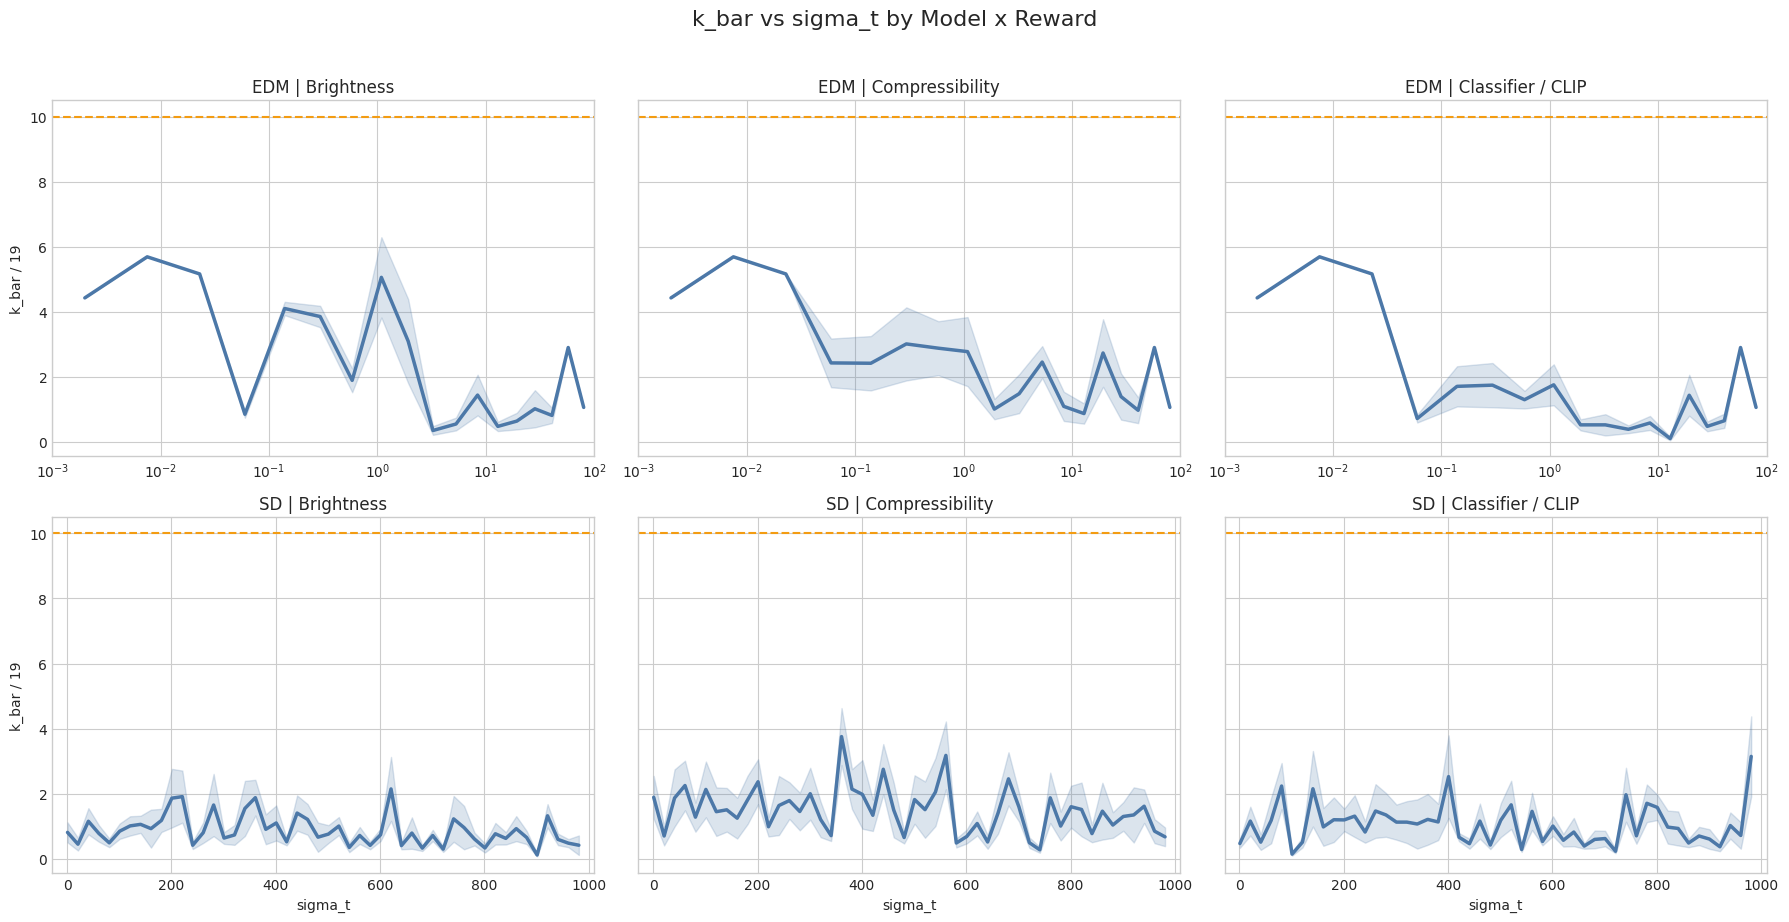

{'EDM': (0.001, 100.0), 'SD': (-28.4, 1010.4)}

In [19]:
baseline = 10.0 if NORMALIZE_BY_19 else 190.0
ylabel = 'k_bar / 19' if NORMALIZE_BY_19 else 'k_bar'


def infer_model_xlim(model: str):
    manual = X_LIM_BY_MODEL.get(model)
    if manual is not None:
        return manual

    sigmas = []
    for col_key in COL_KEYS:
        curve = panel[(model, col_key)]['curve']
        if curve is None or curve.empty:
            continue
        sigmas.extend(curve['sigma_t'].dropna().tolist())

    if not sigmas:
        return None

    arr = np.asarray(sigmas, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return None

    x_scale = X_SCALE_BY_MODEL.get(model, 'log')
    if x_scale == 'log':
        arr = arr[arr > 0]
        if arr.size == 0:
            return None
        lo = 10 ** np.floor(np.log10(arr.min()))
        hi = 10 ** np.ceil(np.log10(arr.max()))
        if lo == hi:
            lo /= 10.0
            hi *= 10.0
        return (float(lo), float(hi))

    lo = float(arr.min())
    hi = float(arr.max())
    if lo == hi:
        lo -= 1.0
        hi += 1.0
    pad = 0.03 * (hi - lo)
    return (lo - pad, hi + pad)


xlim_by_model = {model: infer_model_xlim(model) for model in MODELS}

fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=True)
for r, model in enumerate(MODELS):
    model_xlim = xlim_by_model.get(model)
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')

    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        entry = panel[(model, col_key)]
        curve = entry['curve']

        if curve is None or curve.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        ax.plot(curve['sigma_t'], curve['k_bar_mean'], linewidth=2.5, color='#4C78A8')
        ax.fill_between(
            curve['sigma_t'],
            curve['k_bar_mean'] - curve['k_bar_se'],
            curve['k_bar_mean'] + curve['k_bar_se'],
            alpha=0.2,
            color='#4C78A8',
        )
        ax.axhline(baseline, color='#F39C12', linestyle='--', linewidth=1.5)
        ax.set_title(f'{model} | {COL_LABELS[col_key]}')

        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))

        if model_xlim is not None:
            ax.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('sigma_t')
for ax in axes[:, 0]:
    ax.set_ylabel(ylabel)

fig.suptitle('k_bar vs sigma_t by Model x Reward', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

xlim_by_model



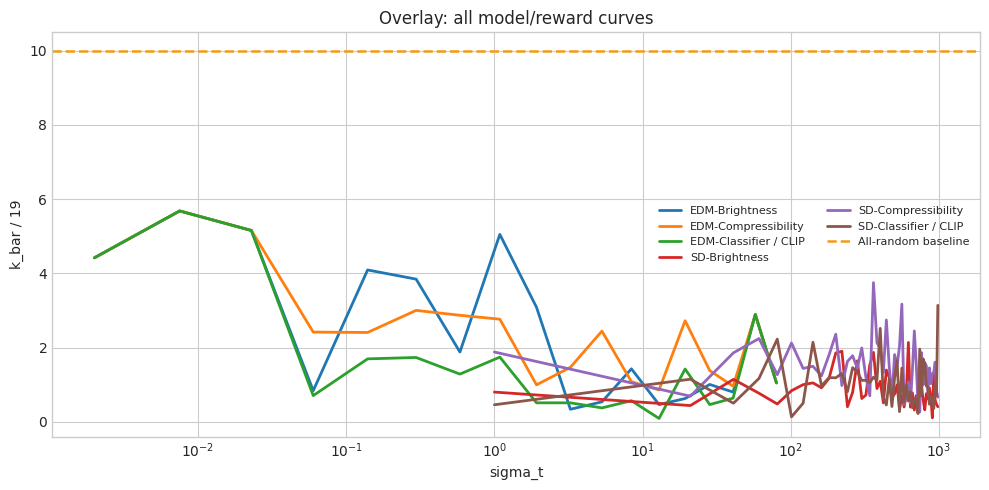

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
for model in MODELS:
    for col_key in COL_KEYS:
        curve = panel[(model, col_key)]['curve']
        if curve is None or curve.empty:
            continue
        label = f"{model}-{COL_LABELS[col_key]}"
        ax.plot(curve['sigma_t'], curve['k_bar_mean'], linewidth=2, label=label)

ax.axhline(baseline, color='#F39C12', linestyle='--', linewidth=1.8, label='All-random baseline')
ax.set_title('Overlay: all model/reward curves')
ax.set_xlabel('sigma_t')
ax.set_ylabel(ylabel)
ax.set_xscale('log')
ax.xaxis.set_major_locator(LogLocator(base=10.0))
ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))
ax.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


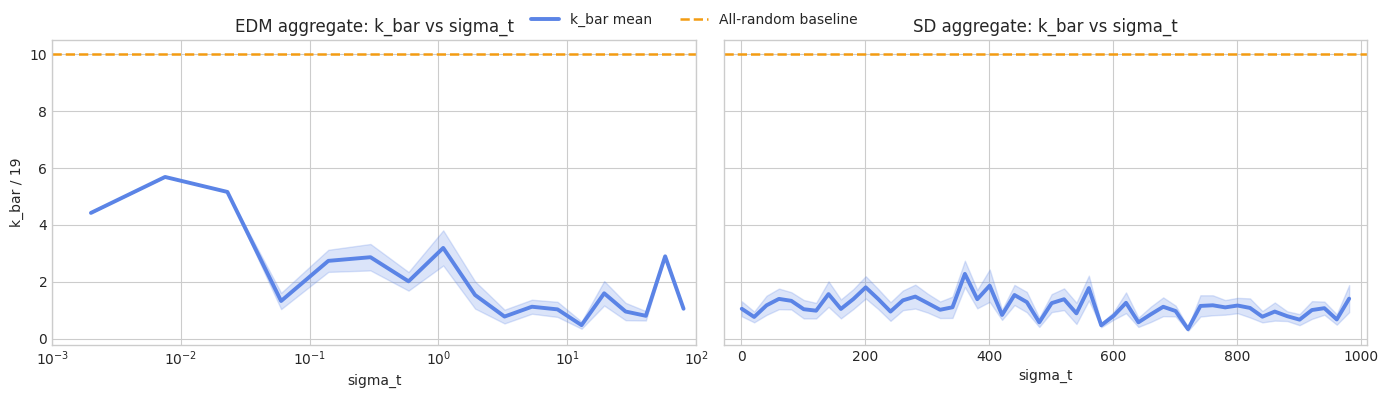

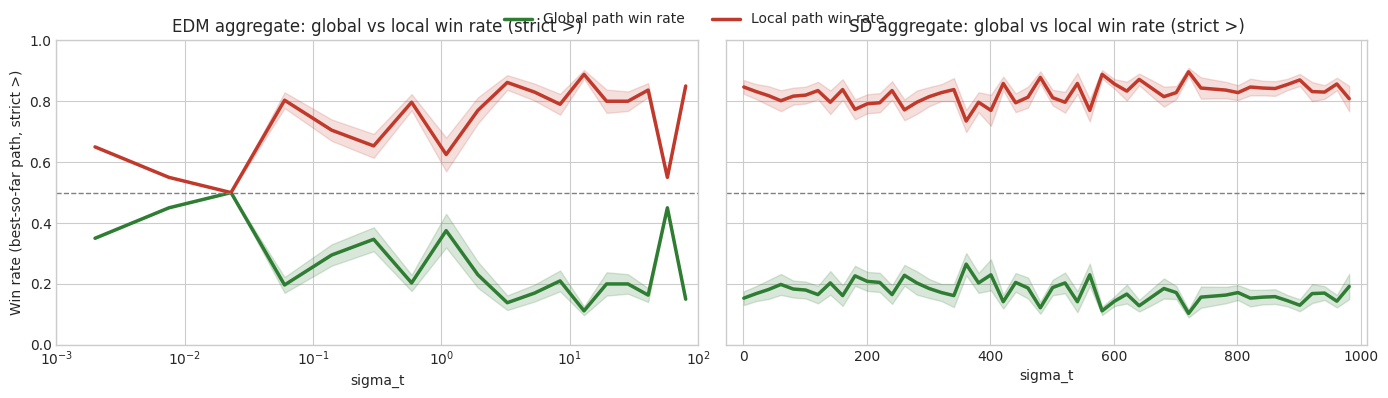

,model,column,reward_dir,log_dir,num_files,num_rows,num_units,num_win_units,strict_win_rate
0,EDM,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/EDM/BRIGHTNESS,1,14400,180,180,True
1,EDM,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/EDM/COMPRESS...,1,14400,180,180,True
2,EDM,classifier_or_clip,CLASSIFIER,../logs/search_stats/inefficiency/EDM/CLASSIFIER,1,14400,180,180,True
3,SD,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/SD/BRIGHTNESS,10,40000,500,500,True
4,SD,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/SD/COMPRESSI...,10,40000,500,500,True
5,SD,classifier_or_clip,CLIP,../logs/search_stats/inefficiency/SD/CLIP,10,40000,500,500,True


In [21]:
if not all_units:
    raise RuntimeError('No panel had data; cannot build model-level aggregates')

if not all_win_units:
    raise RuntimeError('No panel had data; cannot build win-rate aggregates')

model_kbar_curves = {}
model_win_curves = {}
for model in MODELS:
    model_units = [panel[(model, c)]['units'] for c in COL_KEYS if panel[(model, c)]['units'] is not None and not panel[(model, c)]['units'].empty]
    model_win_units = [panel[(model, c)]['win_units'] for c in COL_KEYS if panel[(model, c)]['win_units'] is not None and not panel[(model, c)]['win_units'].empty]

    if model_units:
        mdf = pd.concat(model_units, ignore_index=True)
        mk = (
            mdf.groupby('timestep_idx', as_index=False)
               .agg(
                   sigma_t=('sigma_t', 'mean'),
                   k_bar_mean=('k_bar', 'mean'),
                   k_bar_se=('k_bar', 'sem'),
                   n_units=('k_bar', 'count'),
               )
               .sort_values('sigma_t')
        )
        mk['k_bar_se'] = mk['k_bar_se'].fillna(0.0)
        model_kbar_curves[model] = mk

    if model_win_units:
        wdf = pd.concat(model_win_units, ignore_index=True)
        mw = (
            wdf.groupby('timestep_idx', as_index=False)
               .agg(
                   sigma_t=('sigma_t', 'mean'),
                   global_win_rate_mean=('global_win_rate_bsf', 'mean'),
                   global_win_rate_se=('global_win_rate_bsf', 'sem'),
                   local_win_rate_mean=('local_win_rate_bsf', 'mean'),
                   local_win_rate_se=('local_win_rate_bsf', 'sem'),
                   n_units=('global_win_rate_bsf', 'count'),
               )
               .sort_values('sigma_t')
        )
        mw['global_win_rate_se'] = mw['global_win_rate_se'].fillna(0.0)
        mw['local_win_rate_se'] = mw['local_win_rate_se'].fillna(0.0)
        model_win_curves[model] = mw

# ---- k_bar aggregate by model ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
if len(MODELS) == 1:
    axes = [axes]

for i, model in enumerate(MODELS):
    ax = axes[i]
    curve = model_kbar_curves.get(model)
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')

    if curve is None or curve.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model} aggregate')
        continue

    ax.plot(curve['sigma_t'], curve['k_bar_mean'], linewidth=2.8, color='#5B84E6', label='k_bar mean')
    ax.fill_between(
        curve['sigma_t'],
        curve['k_bar_mean'] - curve['k_bar_se'],
        curve['k_bar_mean'] + curve['k_bar_se'],
        alpha=0.22,
        color='#5B84E6',
    )
    ax.axhline(baseline, color='#F39C12', linestyle='--', linewidth=1.8, label='All-random baseline')
    ax.set_title(f'{model} aggregate: k_bar vs sigma_t')
    ax.set_xlabel('sigma_t')

    if x_scale == 'log':
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))

    model_xlim = xlim_by_model.get(model)
    if model_xlim is not None:
        ax.set_xlim(*model_xlim)

axes[0].set_ylabel(ylabel)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# ---- global vs local path win rate aggregate by model ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
if len(MODELS) == 1:
    axes = [axes]

strict_mode = bool(globals().get('STRICT_WIN_RATE', False))

for i, model in enumerate(MODELS):
    ax = axes[i]
    curve = model_win_curves.get(model)
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')

    if curve is None or curve.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model} aggregate win rate')
        continue

    ax.plot(curve['sigma_t'], curve['global_win_rate_mean'], linewidth=2.5, color='#2E7D32', label='Global path win rate')
    ax.fill_between(
        curve['sigma_t'],
        curve['global_win_rate_mean'] - curve['global_win_rate_se'],
        curve['global_win_rate_mean'] + curve['global_win_rate_se'],
        alpha=0.18,
        color='#2E7D32',
    )

    ax.plot(curve['sigma_t'], curve['local_win_rate_mean'], linewidth=2.5, color='#C0392B', label='Local path win rate')
    ax.fill_between(
        curve['sigma_t'],
        curve['local_win_rate_mean'] - curve['local_win_rate_se'],
        curve['local_win_rate_mean'] + curve['local_win_rate_se'],
        alpha=0.16,
        color='#C0392B',
    )

    ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)
    suffix = ' (strict >)' if strict_mode else ''
    ax.set_title(f'{model} aggregate: global vs local win rate{suffix}')
    ax.set_xlabel('sigma_t')

    if x_scale == 'log':
        ax.set_xscale('log')
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))

    model_xlim = xlim_by_model.get(model)
    if model_xlim is not None:
        ax.set_xlim(*model_xlim)

if strict_mode:
    axes[0].set_ylabel('Win rate (best-so-far path, strict >)')
else:
    axes[0].set_ylabel('Win rate (best-so-far path)')
axes[0].set_ylim(0.0, 1.0)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)
plt.tight_layout()
plt.show()

summary_df

